## 探索奥林匹克数据集

In [3]:
import pandas as pd
import numpy as np

奥运会数据的前五行如下所示。我们总共有271,116行和15列。变量包括运动员的姓名、性别、年龄、身高、体重、所属代表队名称、所参与的体育项目、具体赛事，以及他/她参加奥运会的年份、季节和举办城市。此外，数据还记录了该运动员所获得的奖牌（如果有的话）。

In [8]:
# Read in the data set
olympics = pd.read_csv('data/athlete_events.csv')
len(olympics)

271116

In [9]:
olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [11]:
olympics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


### 数据预处理

#### 1 ）缺失值
打印每一列的缺失值情况如下：

In [12]:
print(olympics.isnull().sum())

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64


我们发现身高（Height）、体重（Weight）和年龄（Age）存在大量缺失值。而奖牌（Medal）一列大约有231,333行是NaN，这可以理解为并非所有参赛运动员都能获得奖牌。我们可以将这些缺失值替换为“未获奖”（Did not win）或缩写“DNW”。

In [13]:
olympics['Medal'].fillna('DNW', inplace = True)

In [14]:
print(olympics.isnull().sum())

ID            0
Name          0
Sex           0
Age        9474
Height    60171
Weight    62875
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
dtype: int64


可以看到Medal一列缺失值已经处理完毕，缺失值变为0了

#### 2) NOC - 国家奥林匹克委员会
NOC 负责组织本国人员参加奥运会。

所有的 NOC 是否都对应唯一的代表队（team）？我们可以通过提取 NOC 和 team 两列的唯一组合，并对其进行计数来判断。

In [15]:
print(olympics.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head())

NOC
FRA    160
USA     97
GBR     96
SWE     52
NOR     46
Name: count, dtype: int64


嗯，这看起来很有趣。NOC 代码 "FRA" 居然对应了 160 个代表队？我们可以通过使用一个 NOC 到国家名称的映射表来纠正这个问题。

这个 NOC 映射数据noc_regions.csv包含了 NOC 代码及其对应的国家名称。现在我们需要将原始数据集与 NOC 映射表进行合并，以 NOC 代码作为主键。由于我们希望保留所有参赛国家，即使某些国家在映射表中找不到对应关系，因此需要使用左连接（left join）。对于那些未能匹配成功的国家，我们可以稍后手动进行修正。

In [20]:
# Lets read in the noc_country mapping first
noc_country = pd.read_csv('data/noc_regions.csv')
noc_country.drop('notes', axis = 1 , inplace = True)
noc_country.rename(columns = {'region':'Country'}, inplace = True)
# merging
olympics_merge = olympics.merge(noc_country,
                                left_on = 'NOC',
                                right_on = 'NOC',
                                how = 'left')

即使在合并之后，我们发现奥运会数据中的以下 NOC 代码在 NOC 映射表中找不到对应的国家名称。但数量已经相较于之前显著降低，我们可以通过手动输入来解决这个问题，这里不再赘述

In [22]:
olympics_merge.loc[olympics_merge['Country'].isnull(),['NOC', 'Team']].drop_duplicates()

,NOC,Team
578,SGP,Singapore
6267,ROT,Refugee Olympic Athletes
44376,SGP,June Climene
61080,UNK,Unknown
64674,TUV,Tuvalu
80986,SGP,Rika II
108582,SGP,Singapore-2
235895,SGP,Singapore-1


In [33]:
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='SGP', 'Singapore', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='ROT', 'Refugee Olympic Athletes', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='UNK', 'Unknown', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='TUV', 'Tuvalu', olympics_merge['Country'])


# Put these values from Country into Team
olympics_merge.drop('Team', axis = 1, inplace = True)
olympics_merge.rename(columns = {'Country': 'Team'}, inplace = True)

### 合并 GDP 数据
为了有效研究影响一个国家奖牌总数的因素，我们需要导入按国家和年份划分的 GDP 数据。该 GDP 数据包含国家名称、国家代码、年份以及对应的 GDP 值。下方展示的是 GDP 数据：

In [34]:
# 查看数据
w_gdp = pd.read_csv('data/world_gdp.csv', skiprows = 3)

# 删除不需要的列
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

# 这些列是记录 GDP 的年份，需要将其转换为单列形式以便后续合并
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# 将年份列转换为数值型
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

w_gdp.head()

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN


In [35]:
len(list(set(olympics_merge['NOC'].unique()) - set(w_gdp['Country Code'].unique())))

108

In [36]:
len(list(set(olympics_merge['Team'].unique()) - set(w_gdp['Country Name'].unique())))

6

In [37]:
# Merge to get country code
olympics_merge_ccode = olympics_merge.merge(w_gdp[['Country Name', 'Country Code']].drop_duplicates(),
                                            left_on = 'Team',
                                            right_on = 'Country Name',
                                            how = 'left')

olympics_merge_ccode.drop('Country Name', axis = 1, inplace = True)

# Merge to get gdp too
olympics_merge_gdp = olympics_merge_ccode.merge(w_gdp,
                                                left_on = ['Country Code', 'Year'],
                                                right_on = ['Country Code', 'Year'],
                                                how = 'left')

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)

In [38]:
# Read in the population data
w_pop = pd.read_csv('data/world_pop.csv')

w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
w_pop['Year'] = pd.to_numeric(w_pop['Year'])

w_pop.head()

,Country,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


In [40]:
olympics_complete = olympics_merge_gdp.merge(w_pop,
                                            left_on = ['Country Code', 'Year'],
                                            right_on= ['Country Code', 'Year'],
                                            how = 'left')

olympics_complete.drop('Country', axis = 1, inplace = True)


合并后的数据中存在大量缺失值，这主要有两个原因：

部分国家在 GDP 和人口主数据中找不到对应项；

GDP 和人口数据仅从 1961 年开始提供，而奥运会数据从 1896 年就开始记录。

因此，为了确保数据的完整性与分析的准确性，我们决定仅保留 1961 年及以后的数据进行后续分析。

In [41]:
# 仅保留1961年及以后的夏季奥运会数据
olympics_complete_subset = olympics_complete.loc[(olympics_complete['Year'] > 1960) & (olympics_complete['Season'] == "Summer"), :]

# 重置行索引
olympics_complete_subset = olympics_complete_subset.reset_index()


### 探索性数据分析（Exploratory Data Analysis, EDA）

参赛人数的演变

C:\Users\14351\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\14351\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


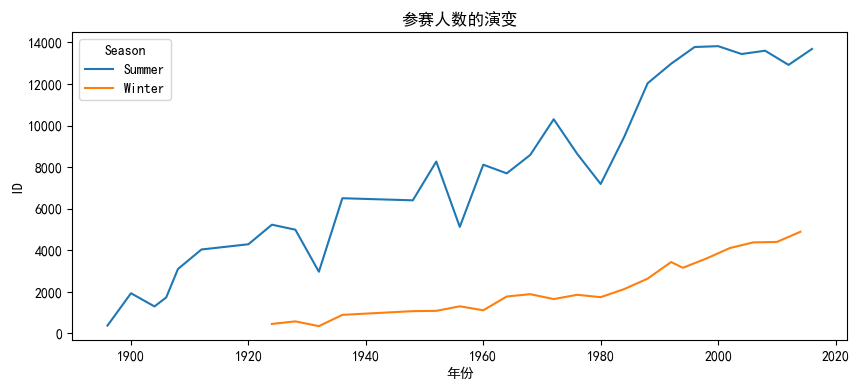

In [43]:
athletes = pd.read_csv("data/athlete_events.csv")
regions = pd.read_csv("data/noc_regions.csv")
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family']='SimHei'        # 设置使用黑体字体以正常显示中文
plt.rcParams['axes.unicode_minus']=False   # 正常显示负号
plt.figure(figsize=(10,4))
y_s_count = athletes.groupby(['Year','Season']).count().loc[:,['ID']].reset_index()
y_s_plot = sns.lineplot(x='Year',y='ID',data = y_s_count, hue='Season')
plt.title("参赛人数的演变")
#plt.tight_layout()
#plt.xticks(np.arange(len(Participants)),labels=x_labels,rotation=40)
plt.xlabel('年份')
plt.show()

最多参与国家可视化


<Axes: xlabel='ID', ylabel='NOC'>

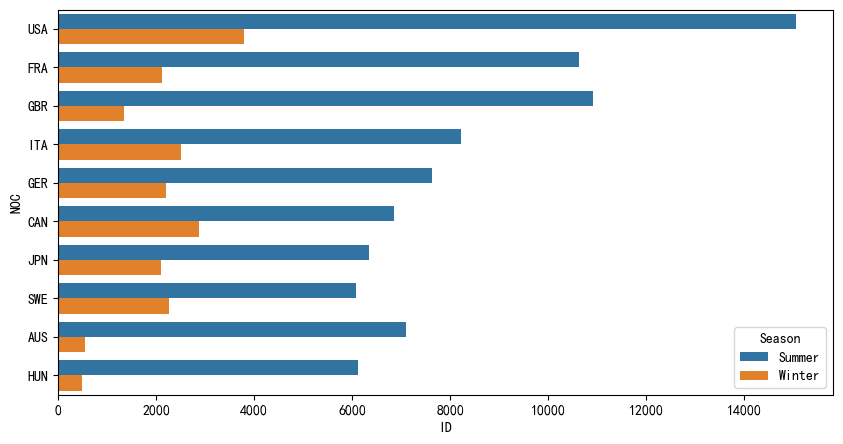

In [44]:
#最多参与人次国家的可视化
Team_group  = athletes.loc[:,['ID','NOC','Season']].groupby(['NOC','Season']).count().sort_values(['ID'], ascending=False).reset_index()

Team_count = athletes.loc[:,['ID','NOC']].groupby(['NOC']).count().reset_index()
Team_count.columns = ['NOC','Total_count']
Team_group_with_total_count = pd.merge(Team_group, Team_count).sort_values(['Total_count'], ascending = False)

plt.figure(figsize=(10,5))
sns.barplot(x='ID',y='NOC',data=Team_group_with_total_count[:20], hue="Season", orient='h')

最少参与国家可视化

<Axes: xlabel='ID', ylabel='NOC'>

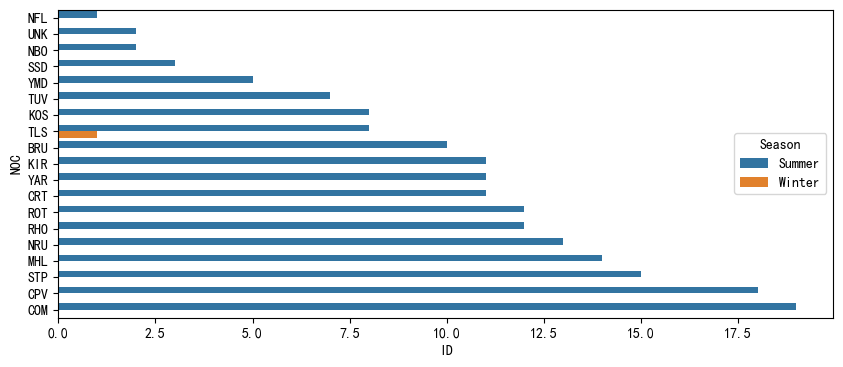

In [46]:
#最少参与人次的国家可视化
plt.figure(figsize=(10,4))
Team_group  = athletes.loc[:,['ID','NOC','Season']].groupby(['NOC','Season']).count().sort_values(['ID'], ascending=True).reset_index()
Team_count = athletes.loc[:,['ID','NOC']].groupby(['NOC']).count().reset_index()
Team_count.columns = ['NOC','Total_count']
Team_group_with_total_count = pd.merge(Team_group, Team_count).sort_values(['Total_count'], ascending = True)

sns.barplot(x='ID',y='NOC',data=Team_group_with_total_count[:20], hue="Season", orient='h')

### 谁是历届奥运会中获得奖牌最多的国家？
奖牌总数是该国家所获得的所有奖牌（包括金、银、铜）的总和。

为此，我们可以先创建一个新列，用来标记该行数据是否获得奖牌：

如果 Medal 列为 Gold、Silver 或 Bronze，则设为 1；

否则设为 0。

In [47]:
olympics_complete_subset['Medal_Won'] = np.where(olympics_complete_subset.loc[:,'Medal'] == 'DNW', 0, 1)

在找出“奖牌最多的国家”之前，我们需要认识到一个关键点：
数据集中每一行代表一位运动员是否获得奖牌。

因此，在团体项目中，同一个奖牌会被记录多次（每个队员一条记录），如果直接对 Medal_Won 列求和，会高估奖牌数。

如何识别团队项目？
我们可以使用以下逻辑识别团队项目：

如果某个国家在某一届奥运会的某项赛事中赢得了不止一个相同等级的奖牌（例如两枚金牌），那这一定是团体项目。

换句话说，同一个国家不可能在个人项目中同时拿下两块金牌，因此出现重复金牌代表该项目为团体项目。

In [48]:
# Check whether number of medals won in a year for an event by a team exceeds 1. This indicates a team event.
identify_team_events = pd.pivot_table(olympics_complete_subset,
                                      index = ['Team', 'Year', 'Event'],
                                      columns = 'Medal',
                                      values = 'Medal_Won',
                                      aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1).reset_index()

identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]

team_sports = identify_team_events['Event'].unique()

下方列出的是在同一届奥运会上出现多枚金牌颁发的项目名称。尽管这些项目被识别为团队项目，但实际上它们并不是团队项目。例如：

体操女子平衡木

体操男子单杠

游泳女子100米自由泳

游泳男子50米自由泳

通过分析发现，这些实际上是个人项目，只是由于两位运动员成绩相同，因此都被授予了金牌。我们需要将这些项目从团队项目列表中移除。

In [49]:
remove_sports = ["Gymnastics Women's Balance Beam", "Gymnastics Men's Horizontal Bar", 
                 "Swimming Women's 100 metres Freestyle", "Swimming Men's 50 metres Freestyle"]

team_sports = list(set(team_sports) - set(remove_sports))

In [50]:
# 如果项目名称在团队项目列表中，则为团体项目；否则为个人项目
team_event_mask = olympics_complete_subset['Event'].map(lambda x: x in team_sports)
single_event_mask = [not i for i in team_event_mask]

# 筛选获得奖牌的行
medal_mask = olympics_complete_subset['Medal_Won'] == 1

# 如果是团体项目且获得奖牌，则在 Team_Event 列标记为 1
olympics_complete_subset['Team_Event'] = np.where(team_event_mask & medal_mask, 1, 0)

# 如果是个人项目且获得奖牌，则在 Single_Event 列标记为 1
olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)

# 添加一个标识列，用于区分是团体项目还是个人项目
olympics_complete_subset['Event_Category'] = olympics_complete_subset['Single_Event'] + \
olympics_complete_subset['Team_Event']


C:\Users\14351\AppData\Local\Temp\ipykernel_12312\455422056.py:12: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)


现在可以计算与队伍人数无关的奖牌总数了 —— 一枚金牌就代表该项目的一枚金牌。

为此，我们需要将奖牌数除以该获奖队伍的成员人数。那如何得到每个队伍的人数呢？对 event_category 列求和即可！

In [52]:
medal_tally_agnostic = olympics_complete_subset.\
groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].\
agg('sum').reset_index()

medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']
# 奖牌计数
medal_tally = medal_tally_agnostic.groupby(['Year','Team'])['Medal_Won_Corrected'].agg('sum').reset_index()

medal_tally_pivot = pd.pivot_table(medal_tally,
                     index = 'Team',
                     columns = 'Year',
                     values = 'Medal_Won_Corrected',
                     aggfunc = 'sum',
                     margins = True).sort_values('All', ascending = False)[1:5]

medal_tally_pivot.loc[:,'All']

Team
USA        1387.0
Russia     1298.0
Germany    1042.0
China       545.0
Name: All, dtype: float64

从1964年到2016年，美国、俄罗斯、德国和中国是奖牌总数最多的四个国家。那么，这些国家的历年奖牌总数趋势是怎样的呢？

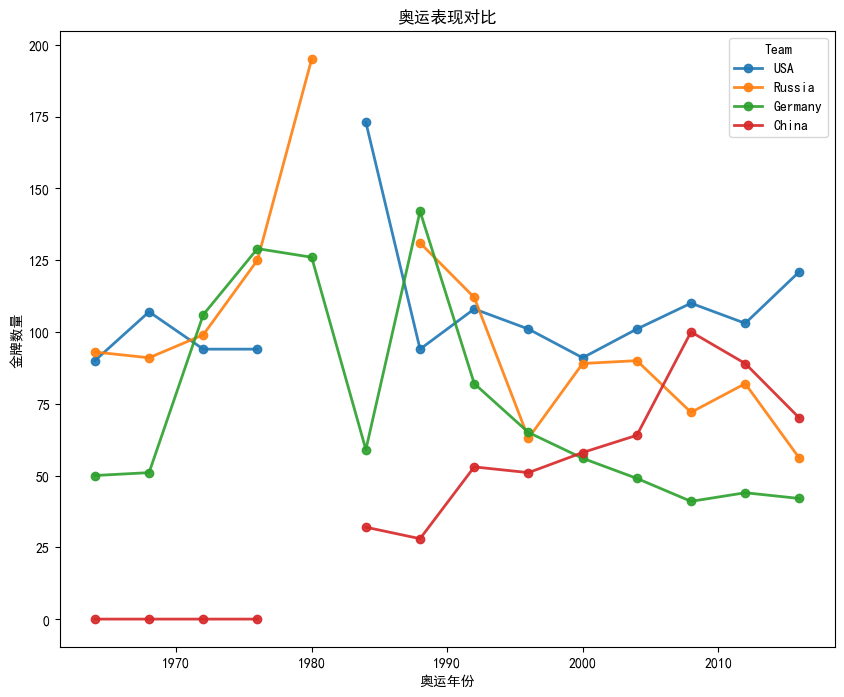

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'SimHei'        # 设置使用黑体字体以正常显示中文
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

# 顶尖国家列表
top_countries = ['USA', 'Russia', 'Germany', 'China']

# 创建透视表：按年份和国家统计奖牌总数
year_team_medals = pd.pivot_table(medal_tally,
                                  index='Year',
                                  columns='Team',
                                  values='Medal_Won_Corrected',
                                  aggfunc='sum')[top_countries]

# 绘制奖牌数量随年份变化的曲线图
year_team_medals.plot(linestyle='-', marker='o', alpha=0.9, figsize=(10, 8), linewidth=2)
plt.xlabel('奥运年份')
plt.ylabel('金牌数量')
plt.title('奥运表现对比')
plt.show()


#### 让我们绘制一张奖牌类型（金牌、银牌、铜牌）的分布图，来展示奖牌总数的构成情况。

Text(0, 0.5, '国家')

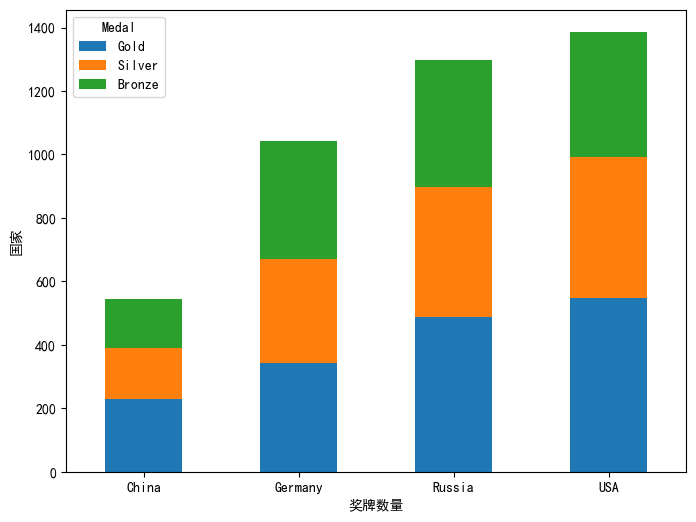

In [57]:
top_countries = ['USA', 'Russia', 'Germany', 'China']
row_mask_2 = medal_tally_agnostic['Team'].map(lambda x: x in top_countries)
medal_tally_specific = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                     index = ['Team'],
                                     columns = 'Medal',
                                     values = 'Medal_Won_Corrected',
                                     aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1)

medal_tally_specific = medal_tally_specific.loc[:, ['Gold', 'Silver', 'Bronze']]
medal_tally_specific.plot(kind = 'bar', stacked = True, figsize = (8,6), rot = 0)
plt.xlabel('奖牌数量')
plt.ylabel('国家')

令人惊讶的是，这些国家的排名在金牌数量上也保持一致！

## 这些国家在奥运会中派出的代表团规模是多少？
1.每个国家派往奥运会的代表团总人数?

2.代表团中男女比例的构成情况?

In [58]:
# 对于每一年，保留团队、运动员姓名和性别，并删除重复项。
# 这些是指同一个运动员参加多个项目的情况。

# 获取属于顶尖国家的行
row_mask_3 = olympics_complete_subset['Team'].map(lambda x: x in top_countries)

year_team_gender = olympics_complete_subset.loc[row_mask_3, ['Year','Team', 'Name', 'Sex']].drop_duplicates()


In [59]:
# 创建数据透视表，统计每个国家在每一年的男女运动员人数
year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# 根据第0级索引名称重命名列
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# 合理地重命名各列
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']

# 计算每个国家-年份对应的运动员总人数
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']


In [60]:
# 分别提取各国家的数据

chi_data = year_team_gender_count[year_team_gender_count['Team'] == "China"]
chi_data.fillna(0, inplace = True)  # 将缺失值填充为0
chi_data.set_index('Year', inplace = True)  # 将“Year”设置为索引

ger_data = year_team_gender_count[year_team_gender_count['Team'] == "Germany"]
ger_data.set_index('Year', inplace = True)

rus_data = year_team_gender_count[year_team_gender_count['Team'] == "Russia"]
rus_data.set_index('Year', inplace = True)

usa_data = year_team_gender_count[year_team_gender_count['Team'] == "USA"]
usa_data.set_index('Year', inplace = True)


C:\Users\14351\AppData\Local\Temp\ipykernel_12312\43700666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_data.fillna(0, inplace = True)  # 将缺失值填充为0


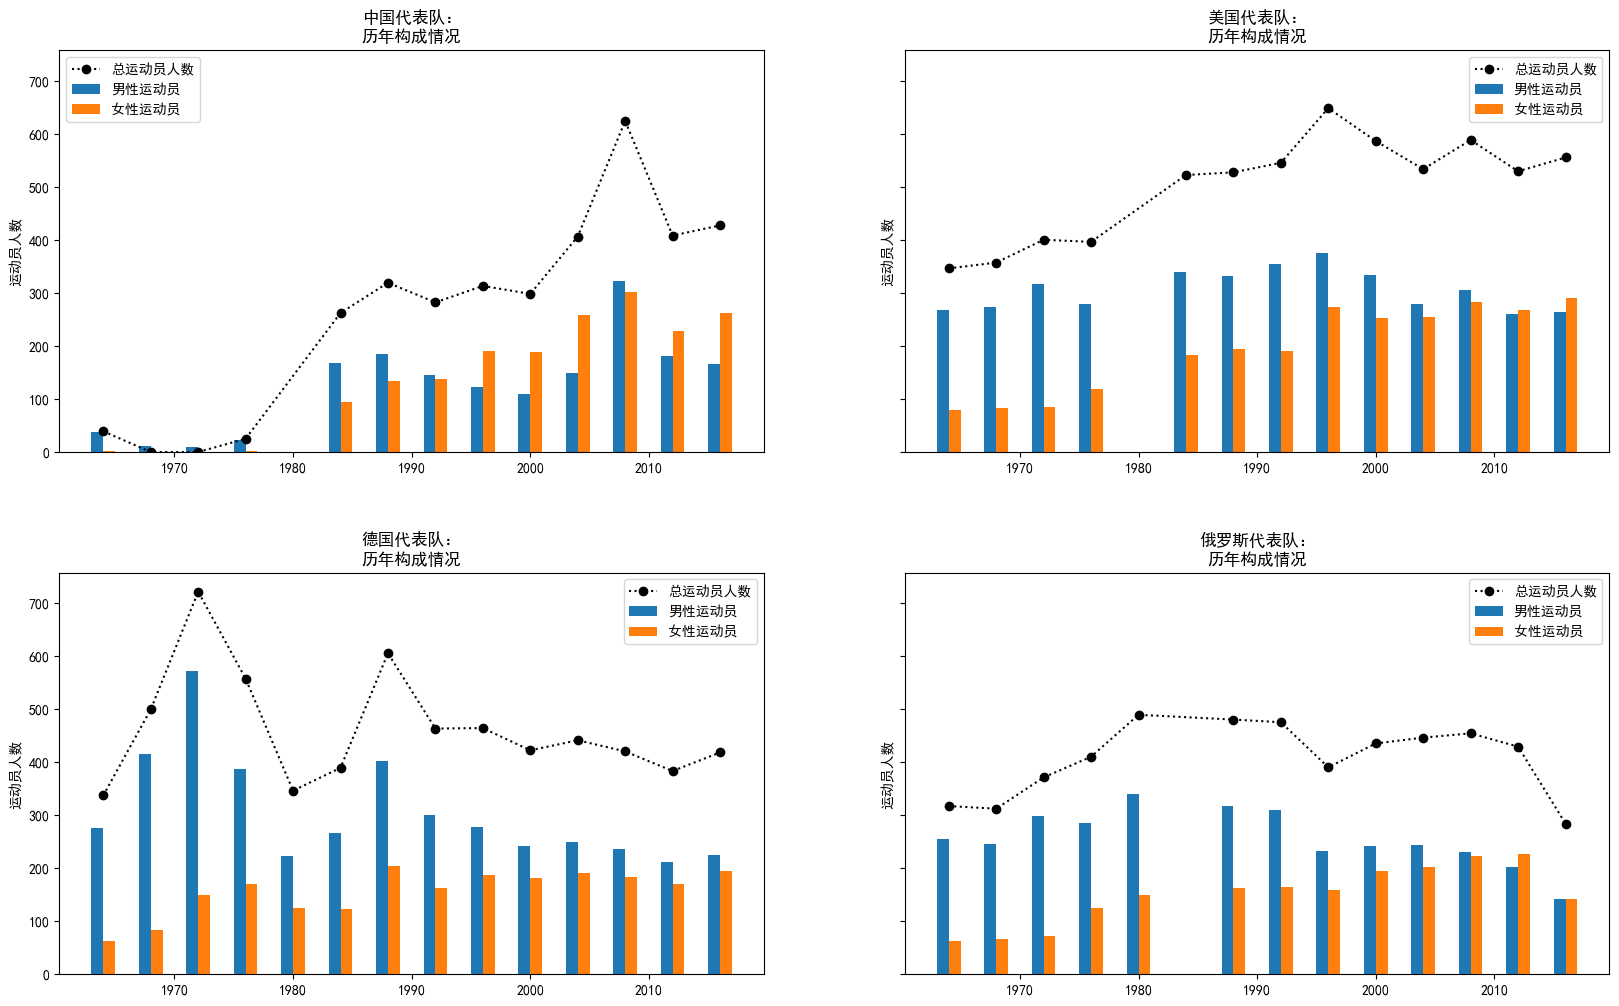

In [65]:
# 绘制男性、女性及总运动员数量的柱状图和折线图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
                                             figsize=(20, 12),
                                             sharey=True)
fig.subplots_adjust(hspace=0.3)

# 绘制中国代表队的代表人数
ax1.bar(chi_data.index.values, chi_data['Male_Athletes'], width = -1, align = 'edge', label = '男性运动员')
ax1.bar(chi_data.index.values, chi_data['Female_Athletes'], width = 1, align = 'edge', label = '女性运动员')
ax1.plot(chi_data.index.values, chi_data['Total_Athletes'], linestyle = ':', color = 'black', label = '总运动员人数',
        marker = 'o')
ax1.set_title('中国代表队：\n历年构成情况')
ax1.set_ylabel('运动员人数')
ax1.legend(loc = 'best')

# 绘制美国代表队的代表人数
ax2.bar(usa_data.index.values, usa_data['Male_Athletes'], width = -1, align = 'edge', label = '男性运动员')
ax2.bar(usa_data.index.values, usa_data['Female_Athletes'], width = 1, align = 'edge', label = '女性运动员')
ax2.plot(usa_data.index.values, usa_data['Total_Athletes'], linestyle = ':', color = 'black', label = '总运动员人数',
        marker = 'o')
ax2.set_title('美国代表队：\n历年构成情况')
ax2.set_ylabel('运动员人数')
ax2.legend(loc = 'best')

# 绘制德国代表队的代表人数
ax3.bar(ger_data.index.values, ger_data['Male_Athletes'], width = -1, align = 'edge', label = '男性运动员')
ax3.bar(ger_data.index.values, ger_data['Female_Athletes'], width = 1, align = 'edge', label = '女性运动员')
ax3.plot(ger_data.index.values, ger_data['Total_Athletes'], linestyle = ':', color = 'black', label = '总运动员人数', 
         marker = 'o')
ax3.set_title('德国代表队：\n历年构成情况')
ax3.set_ylabel('运动员人数')
ax3.legend(loc = 'best')

# 绘制俄罗斯代表队的代表人数
ax4.bar(rus_data.index.values, rus_data['Male_Athletes'], width = -1, align = 'edge', label = '男性运动员')
ax4.bar(rus_data.index.values, rus_data['Female_Athletes'], width = 1, align = 'edge', label = '女性运动员')
ax4.plot(rus_data.index.values, rus_data['Total_Athletes'], linestyle = ':', color = 'black', label = '总运动员人数',
        marker = 'o')
ax4.set_title('俄罗斯代表队：\n历年构成情况')
ax4.set_ylabel('运动员人数')
ax4.legend(loc = 'best')

plt.show()


### 代表团的规模是否与奖牌数量有关？
为探究这一点，我们将绘制各国在不同年份中所获奖牌数量与其在当年派出的代表团规模之间的关系图。

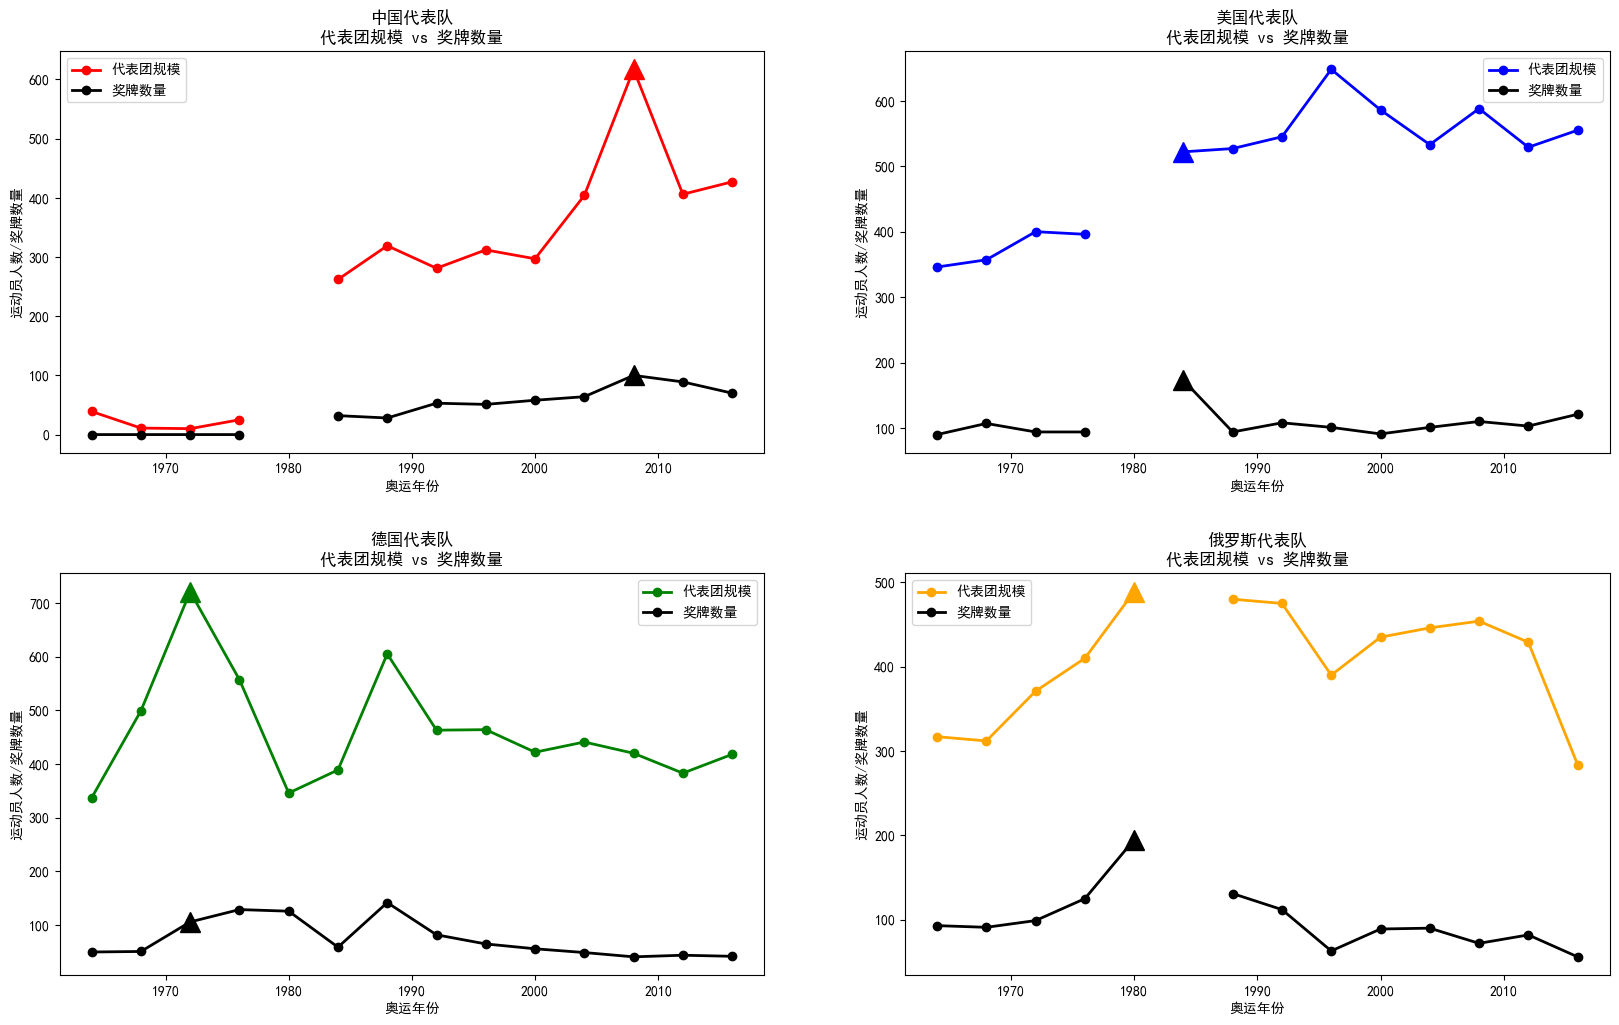

In [67]:
from matplotlib.pyplot import subplots, show
# 获取每年每个国家的运动员信息
year_team_athelete = olympics_complete_subset.loc[row_mask_3, ['Year','Team', 'Name']].drop_duplicates()

# 统计代表团总人数
contingent_size = pd.pivot_table(year_team_athelete,
                                 index = 'Year',
                                 columns = 'Team',
                                 values = 'Name',
                                 aggfunc = 'count')

fig, ((ax1, ax2), (ax3, ax4)) = subplots(nrows = 2,
                                         ncols = 2,
                                        figsize = (20,12))

fig.subplots_adjust(hspace = 0.3)

# 绘制中国代表队的奖牌数量和代表团规模
contingent_size['China'].plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2, color = 'red', 
                                  label = '代表团规模')
year_team_medals['China'].plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                                  label = '奖牌数量')
ax1.plot(2008, contingent_size.loc[2008, 'China'], marker = '^', color = 'red', ms = 14)
ax1.plot(2008, year_team_medals.loc[2008, 'China'], marker = '^', color = 'black', ms = 14)
ax1.set_xlabel('奥运年份')
ax1.set_ylabel('运动员人数/奖牌数量')
ax1.set_title('中国代表队\n代表团规模 vs 奖牌数量')
ax1.legend(loc = 'best')

# 绘制美国代表队的奖牌数量和代表团规模
contingent_size['USA'].plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2, color = 'blue',
                           label = '代表团规模')
year_team_medals['USA'].plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                            label = '奖牌数量')
ax2.plot(1984, contingent_size.loc[1984, 'USA'], marker = '^', color = 'blue', ms = 14)
ax2.plot(1984, year_team_medals.loc[1984, 'USA'], marker = '^', color = 'black', ms = 14)
ax2.set_xlabel('奥运年份')
ax2.set_ylabel('运动员人数/奖牌数量')
ax2.set_title('美国代表队\n代表团规模 vs 奖牌数量')
ax2.legend(loc = 'best')

# 绘制德国代表队的奖牌数量和代表团规模
contingent_size['Germany'].plot(ax = ax3, linestyle = '-', marker = 'o', linewidth = 2, color = 'green',
                               label = '代表团规模')
year_team_medals['Germany'].plot(ax = ax3, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                                label = '奖牌数量')
ax3.plot(1972, year_team_medals.loc[1972, 'Germany'], marker = '^', color = 'black', ms = 14)
ax3.plot(1972, contingent_size.loc[1972, 'Germany'], marker = '^', color = 'green', ms = 14)
ax3.set_xlabel('奥运年份')
ax3.set_ylabel('运动员人数/奖牌数量')
ax3.set_title('德国代表队\n代表团规模 vs 奖牌数量')
ax3.legend(loc = 'best')

# 绘制俄罗斯代表队的奖牌数量和代表团规模
contingent_size['Russia'].plot(ax = ax4, linestyle = '-', marker = 'o', linewidth = 2, color = 'orange',
                              label = '代表团规模')
year_team_medals['Russia'].plot(ax = ax4, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                               label = '奖牌数量')
ax4.plot(1980, contingent_size.loc[1980, 'Russia'], marker = '^', color = 'orange', ms = 14)
ax4.plot(1980, year_team_medals.loc[1980, 'Russia'], marker = '^', color = 'black', ms = 14)
ax4.set_xlabel('奥运年份')
ax4.set_ylabel('运动员人数/奖牌数量')
ax4.set_title('俄罗斯代表队\n代表团规模 vs 奖牌数量')
ax4.legend(loc = 'best')

show()


有趣的是，我们可以看到对于这些国家来说，代表团人数的高峰往往对应奖牌数量的高峰！在图中，这些点已被标记为大的三角形。

接下来，我们将计算代表团规模与奖牌总数之间的相关系数（correlation coefficient）。
这次我们将扩展范围，对所有国家进行分析，以获取更多数据，从而更全面地了解这两者之间的相关性。

In [69]:
# 合并代表团规模和获得的奖牌数量 并计算相关系数
year_team_medals_unstack = year_team_medals.unstack().reset_index()
year_team_medals_unstack.columns = ['Team','Year', 'Medal_Count']

contingent_size_unstack = contingent_size.unstack().reset_index()

contingent_size_unstack.columns = ['Team','Year', 'Contingent']

contingent_medals = contingent_size_unstack.merge(year_team_medals_unstack,
                                                 left_on = ['Team', 'Year'],
                                                 right_on = ['Team', 'Year'])

contingent_medals[['Contingent', 'Medal_Count']].corr()

,Contingent,Medal_Count
Contingent,1.000000,0.703625
Medal_Count,0.703625,1.000000


上方的相关系数矩阵验证了我从图表中得出的结论： 代表团规模与奖牌总数之间存在较强的正相关性（0.703）。

有趣的是，正如我们将在接下来的分析中看到的那样，几个顶尖的国家代表团规模达到峰值的那一届奥运会，正是奥运会在本国举办的那一年。

## GDP 是否影响奖牌总数？
GDP 是衡量一个国家资源状况的代表指标。GDP 越高，意味着国家拥有更多资源可以投入到体育发展中！

C:\Users\14351\AppData\Local\Temp\ipykernel_12312\4100595624.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correlation = medal_tally_gdp.loc[row_mask_5, ['GDP', 'Medal_Won_Corrected']].corr()['Medal_Won_Corrected'][0]


Text(7101223999999.844, 145.0, '相关系数 = 0.6229032997622935')

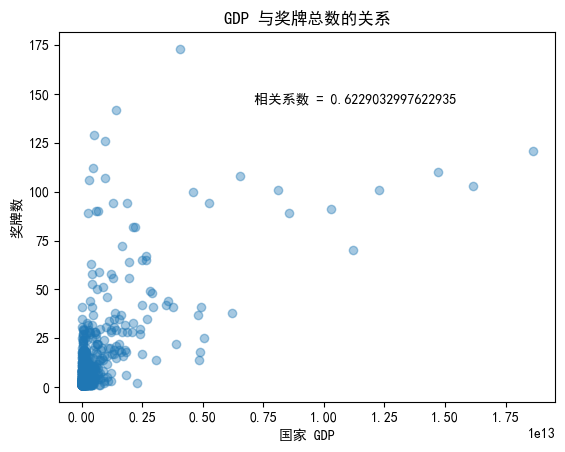

In [74]:
from matplotlib.pyplot import plot
# 提取每年各国家（代表队）的GDP数据，并去重
year_team_gdp = olympics_complete_subset.loc[:, ['Year', 'Team', 'GDP']].drop_duplicates()

# 将GDP信息合并到奖牌数据中
medal_tally_gdp = medal_tally.merge(year_team_gdp,
                                   left_on = ['Year', 'Team'],
                                   right_on = ['Year', 'Team'],
                                   how = 'left')

# 仅保留获得过奖牌的记录
row_mask_5 = medal_tally_gdp['Medal_Won_Corrected'] > 0
# 仅保留指定的主要国家
row_mask_6 = medal_tally_gdp['Team'].map(lambda x: x in top_countries)

# 计算GDP与奖牌数之间的相关性
correlation = medal_tally_gdp.loc[row_mask_5, ['GDP', 'Medal_Won_Corrected']].corr()['Medal_Won_Corrected'][0]

# 绘制GDP与奖牌数的散点图
plot(medal_tally_gdp.loc[row_mask_5, 'GDP'], 
     medal_tally_gdp.loc[row_mask_5, 'Medal_Won_Corrected'] , 
     linestyle = 'none', 
     marker = 'o',
    alpha = 0.4)
plt.xlabel('国家 GDP')  # 横轴标签
plt.ylabel('奖牌数')     # 纵轴标签
plt.title('GDP 与奖牌总数的关系')  # 图标题
plt.text(np.nanpercentile(medal_tally_gdp['GDP'], 99.6), 
     max(medal_tally_gdp['Medal_Won_Corrected']) - 50,
     "相关系数 = " + str(correlation))  # 标注相关系数


图表显示，GDP 与奖牌数量之间的相关系数为 0.622，这是一个显著的正相关关系。

因此，GDP 确实对一个代表队赢得奖牌的数量具有正向影响。

## 我们能预测一个国家的奖牌总数吗？
在数据探索阶段，我们发现以下因素会影响一个国家的奖牌总数：

GDP（国内生产总值）

代表团规模（Contingent Size）

人口数量（Population）

主场优势（Home Field Advantage）

In [94]:
olympics_complete_subset[['Year', 'City']].drop_duplicates().sort_values('Year')

,Year,City
74,1964,Tokyo
11,1968,Mexico City
12,1972,Munich
37,1976,Montreal
70,1980,Moscow
10,1984,Los Angeles
13,1988,Seoul
0,1992,Barcelona
3,1996,Atlanta
2,2000,Sydney


In [95]:
# Correct city names in the dataset
olympics_complete_subset['City'].replace(['Athina', 'Moskva'], ['Athens', 'Moscow'], inplace = True)

In [96]:
# city to country mapping dictionary
city_to_country = {'Tokyo': 'Japan',
                  'Mexico City': 'Mexico',
                  'Munich': 'Germany',
                  'Montreal': 'Canada',
                  'Moscow': 'Russia',
                  'Los Angeles': 'USA',
                  'Seoul': 'South Korea',
                  'Barcelona': 'Spain',
                  'Atlanta': 'USA',
                  'Sydney': 'Australia',
                  'Athens': 'Greece',
                  'Beijing': 'China',
                  'London': 'UK',
                  'Rio de Janeiro': 'Brazil'}

# Map cities to countries
olympics_complete_subset['Country_Host'] = olympics_complete_subset['City'].map(city_to_country)

#print the 
olympics_complete_subset.loc[:, ['Year', 'Country_Host']].drop_duplicates().sort_values('Year')

,Year,Country_Host
74,1964,Japan
11,1968,Mexico
12,1972,Germany
37,1976,Canada
70,1980,Russia
10,1984,USA
13,1988,South Korea
0,1992,Spain
3,1996,USA
2,2000,Australia


In [97]:
# Extract year, host nation and team name from the data
year_host_team = olympics_complete_subset[['Year', 'Country_Host', 'Team']].drop_duplicates()

# check rows where host country is the same as team
row_mask_4 = (year_host_team['Country_Host'] == year_host_team['Team'])

# add years in the year_host_team to capture one previous and one later year
year_host_team['Prev_Year'] = year_host_team['Year'] - 4
year_host_team['Next_Year'] = year_host_team['Year'] + 4

# Subset only where host nation and team were the same
year_host_team = year_host_team[row_mask_4]

# Calculate the medals won in each year where a team played at home. merge year_host_team with medal_tally on year and team
year_host_team_medal = year_host_team.merge(medal_tally,
                                           left_on = ['Year', 'Team'],
                                           right_on = ['Year', 'Team'],
                                           how = 'left')

year_host_team_medal.rename(columns = {'Medal_Won_Corrected' : 'Medal_Won_Host_Year'}, inplace = True)

# Calculate medals won by team in previous year
year_host_team_medal = year_host_team_medal.merge(medal_tally,
                                                 left_on = ['Prev_Year', 'Team'],
                                                 right_on = ['Year', 'Team'],
                                                 how = 'left')

year_host_team_medal.drop('Year_y', axis = 1, inplace = True)
year_host_team_medal.rename(columns = {'Medal_Won_Corrected': 'Medal_Won_Prev_Year',
                                      'Year_x':'Year'}, inplace = True)

# Calculate the medals won by the team the year after they hosted.
year_host_team_medal = year_host_team_medal.merge(medal_tally,
                                                 left_on = ['Next_Year', 'Team'],
                                                 right_on = ['Year', 'Team'],
                                                 how = 'left')

year_host_team_medal.drop('Year_y', axis = 1, inplace = True)
year_host_team_medal.rename(columns = {'Year_x': 'Year',
                                      'Medal_Won_Corrected' : 'Medal_Won_Next_Year'}, inplace = True)

# General formatting changes
year_host_team_medal.drop(['Prev_Year', 'Next_Year'], axis = 1, inplace = True)
year_host_team_medal.sort_values('Year', ascending = True, inplace = True)
year_host_team_medal.reset_index(inplace = True, drop = True)

# column re-ordering
year_host_team_medal = year_host_team_medal.loc[:, ['Year', 'Country_Host', 'Team', 'Medal_Won_Prev_Year', 'Medal_Won_Host_Year', 'Medal_Won_Next_Year']]

year_host_team_medal

,Year,Country_Host,Team,Medal_Won_Prev_Year,Medal_Won_Host_Year,Medal_Won_Next_Year
0,1964,Japan,Japan,NaN,29.0,25.0
1,1968,Mexico,Mexico,1.0,9.0,1.0
2,1972,Germany,Germany,51.0,106.0,129.0
3,1976,Canada,Canada,5.0,11.0,NaN
4,1980,Russia,Russia,125.0,195.0,NaN
5,1984,USA,USA,NaN,173.0,94.0
6,1988,South Korea,South Korea,19.0,33.0,28.0
7,1992,Spain,Spain,4.0,22.0,17.0
8,1996,USA,USA,108.0,101.0,91.0
9,2000,Australia,Australia,41.0,58.0,50.0


In [98]:
# 创建每年每支代表队的参赛性别数据
year_team_gender = olympics_complete_subset.loc[:,['Year','Team', 'Name', 'Sex']].drop_duplicates()

year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# 根据第0层的列名重命名列
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# 正确重命名列名
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']
year_team_gender_count = year_team_gender_count.fillna(0)

# 计算每年每支代表队的总参赛人数
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']

year_team_contingent = year_team_gender_count.loc[:, ['Year', 'Team','Total_Athletes']]
year_team_contingent.head()


,Year,Team,Total_Athletes
0,1964,Afghanistan,8.0
1,1964,Algeria,1.0
2,1964,Argentina,102.0
3,1964,Australia,243.0
4,1964,Austria,56.0


In [99]:
# 获取年份、代表队和GDP信息 —— medal_tally_gdp 已经包含这些数据
medal_tally_gdp.head()

,Year,Team,Medal_Won_Corrected,GDP
0,1964,Afghanistan,0.0,8.000000e+08
1,1964,Algeria,0.0,2.909352e+09
2,1964,Argentina,1.0,2.560525e+10
3,1964,Australia,18.0,2.378766e+10
4,1964,Austria,0.0,9.169984e+09


In [100]:
# 获取每年队伍的人数
year_team_pop = olympics_complete_subset.loc[:, ['Year', 'Team', 'Population']].drop_duplicates()
year_team_pop.head()

,Year,Team,Population
0,1992,China,1.164970e+09
1,2012,China,1.350695e+09
2,2000,Finland,5.176209e+06
3,1996,Finland,5.124573e+06
6,2008,Norway,4.768212e+06


In [101]:
# 一起合并所有的数据集
medal_gdp_population = medal_tally_gdp.merge(year_team_pop,
                                            left_on = ['Year', 'Team'],
                                            right_on = ['Year', 'Team'],
                                            how = 'left')

medal_gdp_pop_contingent = medal_gdp_population.merge(year_team_contingent,
                                                     left_on = ['Year', 'Team'],
                                                     right_on = ['Year', 'Team'],
                                                     how = 'left')
medal_gdp_pop_contingent.head()

,Year,Team,Medal_Won_Corrected,GDP,Population,Total_Athletes
0,1964,Afghanistan,0.0,8.000000e+08,9731361.0,8.0
1,1964,Algeria,0.0,2.909352e+09,12295970.0,1.0
2,1964,Argentina,1.0,2.560525e+10,21953929.0,102.0
3,1964,Australia,18.0,2.378766e+10,11167000.0,243.0
4,1964,Austria,0.0,9.169984e+09,7223801.0,56.0


In [102]:
# get host nation from the data
year_host = olympics_complete_subset.loc[:, ['Year', 'Country_Host']].drop_duplicates()

# merge this with the larger dataset
lin_model_data = medal_gdp_pop_contingent.merge(year_host,
                              left_on = 'Year',
                              right_on = 'Year',
                              how = 'left')

lin_model_data.head()

,Year,Team,Medal_Won_Corrected,GDP,Population,Total_Athletes,Country_Host
0,1964,Afghanistan,0.0,8.000000e+08,9731361.0,8.0,Japan
1,1964,Algeria,0.0,2.909352e+09,12295970.0,1.0,Japan
2,1964,Argentina,1.0,2.560525e+10,21953929.0,102.0,Japan
3,1964,Australia,18.0,2.378766e+10,11167000.0,243.0,Japan
4,1964,Austria,0.0,9.169984e+09,7223801.0,56.0,Japan


Text(0.5, 1.0, '人口分布')

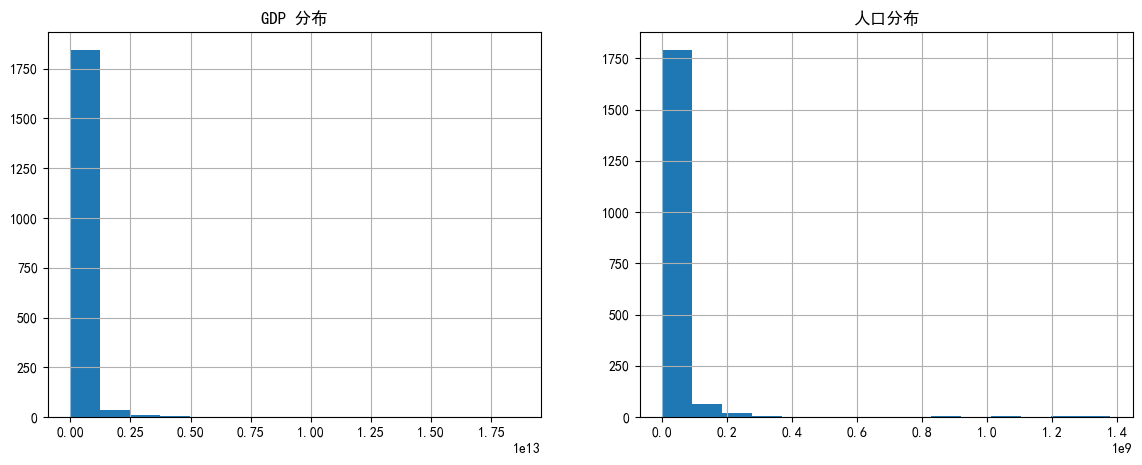

In [105]:
# # 回归模型
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import metrics

# 添加主场优势指标
lin_model_data['Home_adv'] = np.where(lin_model_data['Country_Host'] == lin_model_data['Team'], 1, 0)

# 添加人均GDP
lin_model_data['GDP_per_capita'] = lin_model_data['GDP']/lin_model_data['Population']

# 删除缺失值
lin_model_data.dropna(how = 'any', inplace = True)


# 使用直方图查看人口和GDP的分布情况

fig, (ax1, ax2) = subplots(nrows = 1,
                          ncols = 2,
                          figsize = (14,5))

lin_model_data['GDP'].hist(bins = 15, ax = ax1)
ax1.set_title('GDP 分布')

lin_model_data['Population'].hist(bins = 15, ax = ax2)
ax2.set_title('人口分布')

图表显示，这些变量存在严重的偏态分布。因此，对这些变量进行对数变换（log transform），可以在线性回归模型中获得更好的拟合效果。

In [107]:
import math

# 对变量取对数变换
lin_model_data['Log_Population'] = np.log(lin_model_data['Population'])
lin_model_data['Log_GDP'] = np.log(lin_model_data['GDP'])

# 回归模型
y, X = dmatrices('Medal_Won_Corrected ~ Log_GDP + Log_Population + Total_Athletes + Home_adv + GDP_per_capita', 
                data = lin_model_data,
                return_type = 'dataframe')

model = sm.OLS(y, X)
result = model.fit()

result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Medal_Won_Corrected   R-squared:                       0.755
Model:                             OLS   Adj. R-squared:                  0.754
Method:                  Least Squares   F-statistic:                     1170.
Date:                 Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                         15:57:07   Log-Likelihood:                -6455.3
No. Observations:                 1907   AIC:                         1.292e+04
Df Residuals:                     1901   BIC:                         1.296e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         16.6564      2.214      7.525      0.000      12.315      20.998
Log_GDP           -1.1254      0.161     -7.009      0.000      -1.440      -0.811
Log_Population     0.3971      0.155      2.562      0.010       0.093       0.701
Total_Athletes     0.1462      0.002     58.549      0.000       0.141       0.151
Home_adv          -7.9921      2.180     -3.665      0.000     -12.269      -3.716
GDP_per_capita  1.344e-05   1.48e-05      0.907      0.365   -1.56e-05    4.25e-05
==============================================================================
Omnibus:                     1859.147   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           253485.577
Skew:                           4.229   Prob(JB):                         0.00
Kurtosis:                      58.845   Cond. No.                     2.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

上方的回归结果摘要显示 R² 值为 0.75，这是一项不错的结果。

这意味着：这些变量能够解释奖牌总数中约 75% 的变异性。

R² 值达到 75% 虽然说明模型拟合效果较好，但更重要的是在预测一个国家奖牌总数时的误差大小——这个误差不应过大。

下方展示的是模型预测的 RMSE（均方根误差）：

In [108]:
y_predicted = result.predict(X)
np.sqrt(metrics.mean_squared_error(y, y_predicted))

7.142700384582235

上述结果表明，如果我们已知这些预测变量，就能以大约仅有 7 枚奖牌的误差预测一个国家的奖牌总数，说明预测效果良好。

### 我们能仅通过身高和体重预测一名运动员所从事的运动项目吗？

In [111]:
# 有多少个不同的体育项目？
olympics_complete_subset['Sport'].unique()

# 提取男性运动员的体育项目、年龄、体重和身高数据
base_data_male = olympics_complete_subset.loc[olympics_complete_subset['Sex'] == "M",
                                              ['Sport', 'Age','Weight', 'Height']].drop_duplicates()

# 构造K近邻问题所需的 Y（标签）和 X（特征）数据
Y, X = dmatrices('Sport ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')


通过对部分运动项目的可视化，我们发现：

田径（Athletics）和举重（Weightlifting）的选手由于身高或体重特征明显，较容易被区分；

而其他大多数项目，仅凭身高和体重就很难区分清楚，具有较大的重叠性和不确定性。

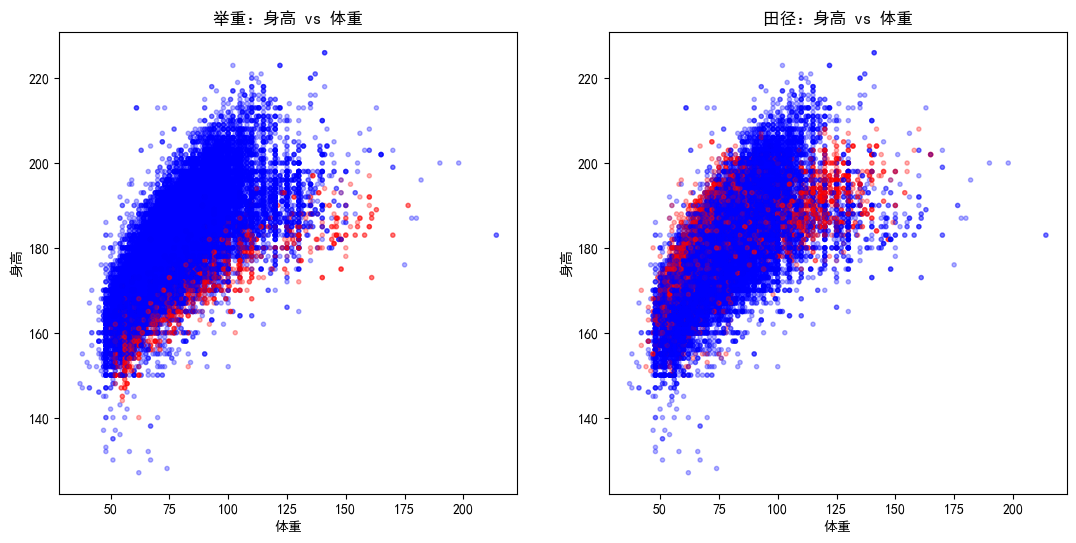

In [113]:
fig, (ax1, ax2) = subplots(nrows = 1, ncols = 2, figsize = (13,6))

ax1.scatter(X['Weight'], X['Height'], c = Y['Sport[Weightlifting]'], cmap = 'bwr', marker = '.', alpha = 0.3)
ax1.set_title('举重：身高 vs 体重')
ax1.set_xlabel('体重')
ax1.set_ylabel('身高')

ax2.scatter(X['Weight'], X['Height'], c = Y['Sport[Athletics]'], cmap = 'bwr', marker = '.', alpha = 0.3)
ax2.set_title('田径：身高 vs 体重')
ax2.set_xlabel('体重')
ax2.set_ylabel('身高')

show()


看看，仅根据身高和体重，我们能多准确地预测一名运动员是否从事**举重（Weightlifting）**项目。

In [114]:
base_data_male['target'] = np.where(base_data_male['Sport'] == 'Weightlifting', 1, 0)

# 构造用于建模的因变量（y）和自变量（X）矩阵
from sklearn import model_selection
from sklearn import metrics
from sklearn import neighbors

Y, X = dmatrices('target ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')

y = Y['target'].values

accuracies = []

kfold = model_selection.StratifiedKFold(n_splits = 5, shuffle = True).split(X, y)

model = neighbors.KNeighborsClassifier(n_neighbors = 20,
                                      p = 2,
                                      weights = 'uniform')

for train, holdout in kfold:
    model.fit(X.iloc[train], y[train])
    prediction_on_test = model.predict(X.iloc[holdout])
    accuracies.append(metrics.accuracy_score(y[holdout], prediction_on_test))

np.mean(accuracies)

0.9689486864019452

上述结果显示，仅通过身高和体重，我们就能以 96% 的准确率预测某人是否是举重选手！ 这主要是因为在身高/体重的散点图中，举重选手的特征非常明显，与其他项目有明显区分。

接下来，让我们尝试预测田径（Athletics）项目的情况！

In [116]:
# 使用身高和体重预测是否为田径项目
base_data_male['target'] = np.where(base_data_male['Sport'] == 'Athletics', 1, 0)

# 创建 y 和 X 矩阵
from sklearn import model_selection
from sklearn import metrics
from sklearn import neighbors

Y, X = dmatrices('target ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')

y = Y['target'].values

accuracies = []

# 使用分层K折交叉验证进行模型评估
kfold = model_selection.StratifiedKFold(n_splits = 5, shuffle = True).split(X, y)

# 构建K近邻分类器，使用欧几里得距离（p=2），权重为均匀
model = neighbors.KNeighborsClassifier(n_neighbors = 20,
                                      p = 2,
                                      weights = 'uniform')

for train, holdout in kfold:
    model.fit(X.iloc[train], y[train])  # 在训练集上拟合模型
    prediction_on_test = model.predict(X.iloc[holdout])  # 在验证集上进行预测
    accuracies.append(metrics.accuracy_score(y[holdout], prediction_on_test))  # 计算准确率并记录

np.mean(accuracies)  # 输出平均准确率


0.8574949297696468

在预测是否为**田径（Athletics）**选手时，使用 K 最近邻（K-Nearest Neighbors, KNN）算法，我们达到了 86% 的预测准确率！

这真是一次令人兴奋的探索之旅！

通过EDA以及相关预测与回归我们可以得出：

美国、俄罗斯、德国和中国是自 1964 年以来奥运奖牌榜上的领军国家。它们在各个时期派出的代表团人数不同，而代表团规模越大，表现通常越好。

女性在早期奥运代表团中占比较小，但如今已实现了性别平等的参赛比例。

1980 年和 1984 年是特殊年份：1980 年美国因抗议苏联入侵阿富汗而缺席，1984 年苏联则发起报复性抵制，举办“友谊运动会”。

GDP 对一个国家获得奖牌数有显著的正向影响！

我们可以通过对 GDP、人口、人均GDP 和代表团规模 进行线性回归预测某国奖牌总数，误差仅约 7 枚奖牌（RMSE）。

使用简单的 K 最近邻模型（KNN），我们甚至可以仅凭运动员的身高和体重预测其所从事的项目（如举重、田径）——当然，这个模型还有很多提升空间！

这次分析为我们提供了对奥运会背后深层规律的宝贵洞察！